In [18]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import networkx as nx
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

from src.functions import *

# Load the data

In [2]:
# create a class to handle the data
class DATA:
    def __init__(self, df_net, G, df_microbiota_bool):
        self.df_net = df_net
        self.G = G
        self.df_microbiota_bool = df_microbiota_bool

In [3]:
df_net = pd.read_csv('ContactNetwork.csv')
df_net.weight = df_net.weight.astype(float)
df_microbiota_bool = pd.read_csv('microbiota.csv')
df_microbiota_bool.set_index('Person ID', inplace = True)

# create a graph
G = nx.from_pandas_edgelist(df_net, source = "pid", target = "pid2", edge_attr = ['weight'])

data = DATA(df_net, G, df_microbiota_bool)

# Microbiota and contacts

Here we consider a slightly different approach: we set different threshold and keep only the contacts whose duration exceeds the threshold. For these, we compute the mean similarity of the microbiome. We plot this value as a function of the threshold and compare it to a null model in which, once again, the contact duration is randomized.

> **Result**: for sufficiently large thresholds (approx 2 hours) we get significant results

In [4]:
# create a complete network with w = 0 for the missing edges
idx1, idx2, weight = [], [], []
all_nodes = np.unique(data.df_net[['pid', 'pid2']])
for pid, pid2 in combinations(all_nodes, 2):
    idx1.append(pid)
    idx2.append(pid2)
    if tuple([pid, pid2]) in data.G.edges:
        weight.append(data.G[pid][pid2]['weight'])
    else:
        weight.append(0)

df_net = pd.DataFrame(np.array([idx1, idx2, weight]).T, columns = ['pid', 'pid2', 'weight'])
df_net.weight = df_net.weight.astype(float)

# similarity of the average taxa for all pairs of interacting nodes
df_net['Sim_microbiome'] = df_net.apply(lambda x: \
        jaccard_similarity(data.df_microbiota_bool.loc[x.pid].values, data.df_microbiota_bool.loc[x.pid2]),\
                                        axis = 1)

# set of thresholds considered (the unit is hours)
tv = np.linspace(0, 6, 6)

# randomize and store in X the mean similarity 
df_net_rdn = copy(df_net)
x = copy(df_net_rdn.weight.values)
X = []
n_sim = 1500

for i in range(n_sim):
    print(i, end = '\r')

    np.random.shuffle(x)
    df_net_rdn.weight = x
    X.append([df_net_rdn[df_net_rdn.weight*10/3600 > t].Sim_microbiome.mean() for t in tv])

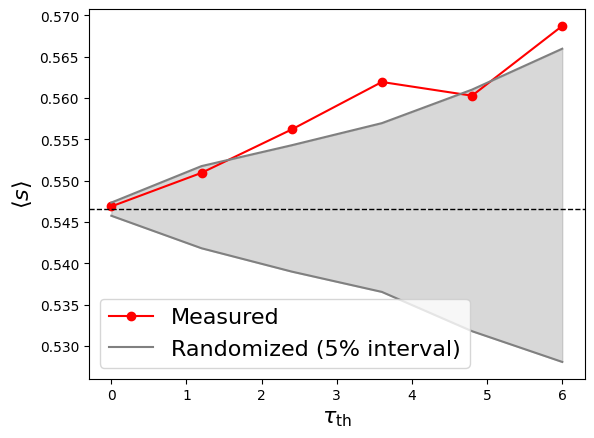

In [5]:
# plot
y = [df_net[df_net.weight*10/3600 > t].Sim_microbiome.mean() for t in tv]
plt.plot(tv, y, color = 'r', label = 'Measured', marker = 'o')

X = np.array(X)
perc = np.array([[np.quantile(X[:,i], 0.05), np.quantile(X[:,i], 0.95)] for i in range(X.shape[1])])
plt.fill_between(tv, perc[:,0], perc[:,1], color = 'grey', alpha = 0.3)
plt.plot(tv, perc[:,0], color = 'grey')
plt.plot(tv, perc[:,1], color = 'grey', label = 'Randomized (5% interval)')
plt.axhline(df_net.Sim_microbiome.mean(), color = 'k', linewidth = 1., linestyle = '--')
plt.xlabel(r'$\tau_{\rm th}$', fontsize = 16)
plt.ylabel(r'$\langle s \rangle$', fontsize = 16)
plt.legend(fontsize = 16, loc = 3)
plt.show();

## Are longer contacts associated with co-presence of some taxa?

For each taxon we perform the following analysis. For all graph edges $e = (ij)$, do the following:

* assign a variable $x_e = 1$ if both $i$ and $j$ ever presented the taxon under analysis
* assign $x_e = 0$ if either of the two (but not both) ever presented that taxon
* discard the edge otherwise

We then compare the cumulative contact duration distributions for all edges so that $x_e = 0$ with those for which $x_e = 1$. We perform the Mann-Whytney U test and consider as relevant only the taxa for which the p-value is below $10^{-4}$.

In [6]:
Psmall, Plarge, Ysingle, Yboth = FindSignificantTaxa(data)

counter = 135


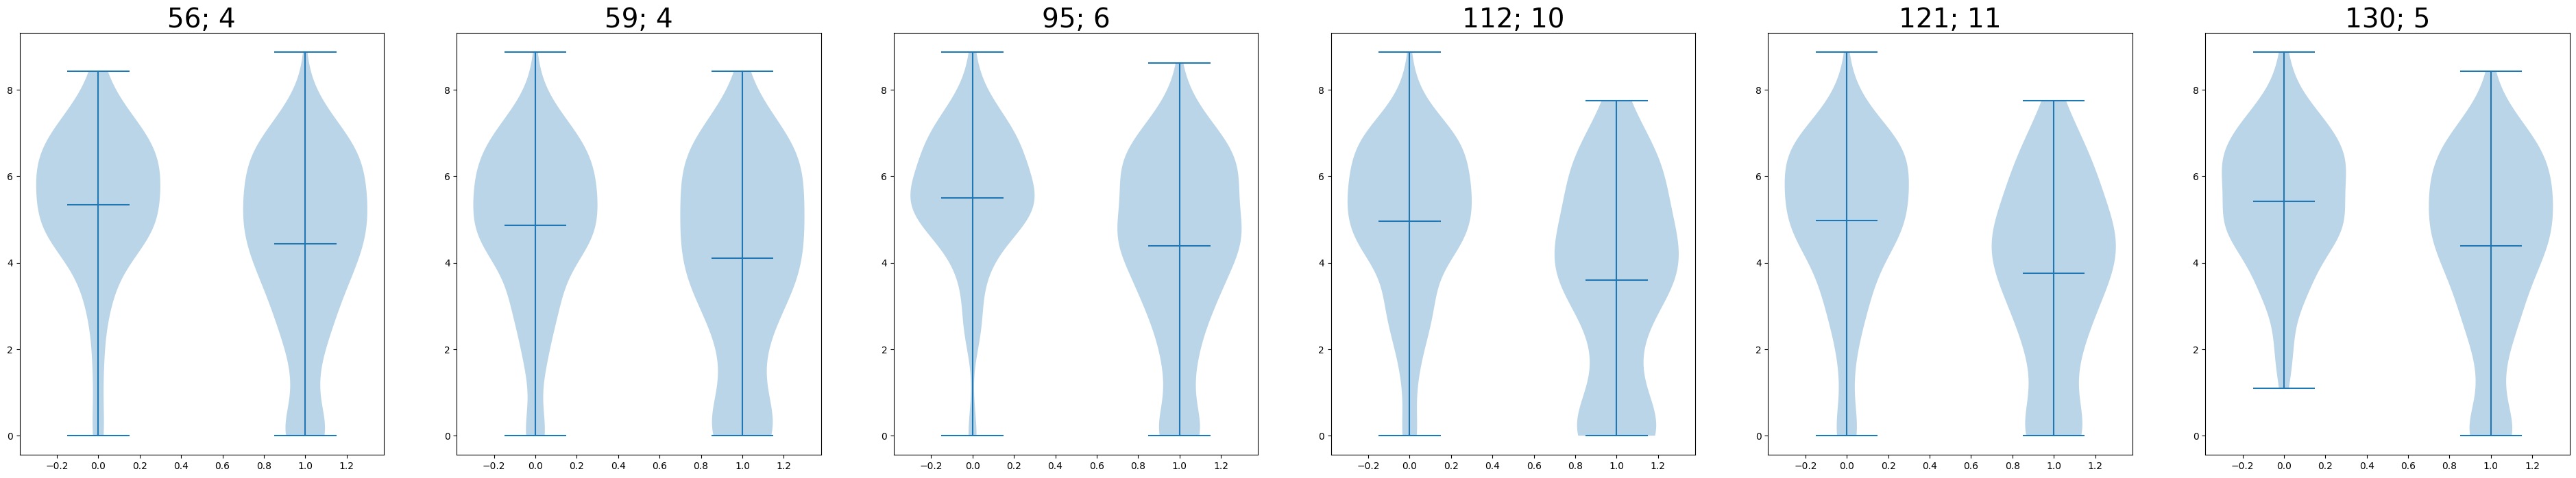

In [7]:
indices_large, pvalues = [], []
ϵ = 1e-4
N = 30
counter = 0

for i in range(len(Yboth)): 
    if len(Yboth[i]) > N and len(Ysingle[i]) > N:
        μ = np.sum(data.df_microbiota_bool.iloc[:,i])
        if μ < 32:
            counter += 1
            if Plarge[i] < ϵ:
                indices_large.append(i)
                pvalues.append(Plarge[i])

print(f'counter = {counter}')
fig, ax = plt.subplots(1, len(indices_large[:6]), figsize = (8*len(indices_large[:6]), 8))

pos = [0,1]

for i, a in enumerate(indices_large[:6]):

    ax[i].violinplot([np.log(Yboth[a]+1), np.log(Ysingle[a]+1)], pos, points = 200, widths = 0.6, showmeans = True, showextrema = True)
    ax[i].set_title(f'{a}; {-int(np.log10(pvalues[i]))}', fontsize = 28)

plt.show();

In [8]:
indices_large = []
ϵ = 0.01 # for large table
N = 30
counts = 0

Psmall_, Plarge_ = [], []

for i in range(len(Yboth)): 
    if len(Yboth[i]) > N and len(Ysingle[i]) > N:
        μ =  np.sum(data.df_microbiota_bool.iloc[:,i])
        if μ < 32 and μ >= 5:
            counts += 1
            if Plarge[i] < ϵ:
                indices_large.append(i)
                Plarge_.append(Plarge[i])

indices_small = []

for i in range(len(Yboth)): 
    if len(Yboth[i]) > N and len(Ysingle[i]) > N:
        μ = np.sum(data.df_microbiota_bool.iloc[:,i])
        if μ < 32 and μ >= 5:
            if Psmall[i] < ϵ:
                indices_small.append(i)
                Psmall_.append(Psmall[i])

# Bonferroni correction
Psmall_ = np.array(Psmall_)*counts
Plarge_ = np.array(Plarge_)*counts          
idx = np.argsort(Psmall_)
indices_small = np.array(indices_small)[idx]
Psmall_ = np.array(Psmall_)[idx]

idx = np.argsort(Plarge_)
indices_large = np.array(indices_large)[idx]
Plarge_ = np.array(Plarge_)[idx]

In [9]:
from decimal import Decimal


def splitname(x):
    try:
        s = x.split('__')[1]
    except:
        s = None
    return s

P = Plarge_
idx = indices_large

# P = Psmall_
# idx = indices_small

df = pd.DataFrame(np.array([[splitname(x) for x in data.df_microbiota_bool.columns[idx][i].split(';')] \
          for i in range(len(idx))]), 
                  columns = ['Domain','Phylum','Class','Order','Family','Genus','Species'])

df = df.iloc[:,1:]
df['code'] = idx
df['P value'] = P
df = df[df['P value'] < 0.05]
df = df.sort_values('P value', ascending = True)
df['P value'] = df['P value'].apply(lambda x: '%.2E' % Decimal(str(x)))
df = df[['P value', 'Class', 'Order', 'Family', 'Genus', 'Species']]
print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format)) 

\begin{tabular}{llllll}
\toprule
 P value &               Class &               Order &               Family &                   Genus &                   Species \\
\midrule
1.06E-09 &         Bacteroidia &       Bacteroidales &   Porphyromonadaceae &           Porphyromonas &    Porphyromonas\_catoniae \\
1.04E-08 &         Bacteroidia &       Bacteroidales &       Prevotellaceae &              Prevotella &      Prevotella\_loescheii \\
1.94E-08 & Gammaproteobacteria &   Cardiobacteriales &   Cardiobacteriaceae &         Cardiobacterium &                           \\
2.14E-06 &          Clostridia &                     &                      &                         &                           \\
3.76E-06 & Gammaproteobacteria &     Burkholderiales &        Neisseriaceae &               Eikenella &      uncultured\_bacterium \\
1.89E-05 &       Fusobacteriia &     Fusobacteriales &     Fusobacteriaceae &           Fusobacterium &         Fusobacterium\_sp. \\
6.43E-05 &             

## Individuals with higher degree have higher diversity in the microbiome

SignificanceResult(statistic=0.7593078248577664, pvalue=1.2374723071875716e-07)

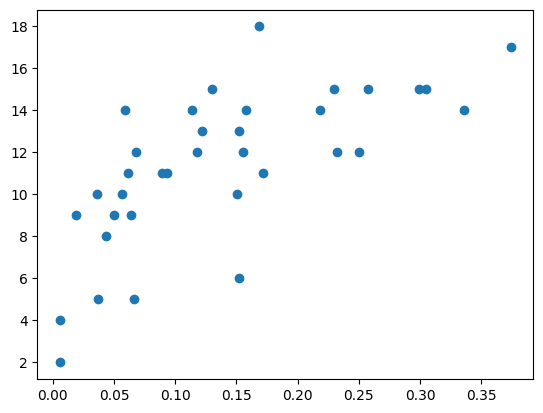

In [10]:
# select only the indices idnetifying the social microbiome
idx = indices_large[Plarge_ < 0.05]

# build the network of contacts and of microbiota similarity

# select the entries of the boolean matrix of abundances corresponding to the social microbiome and to the nodes in the network
df_ = data.df_microbiota_bool.iloc[:,idx].loc[list(data.G.nodes)]

D = nx.eigenvector_centrality(data.G, weight = 'weight')
y = [df_.loc[key].sum() for key in D.keys()]
x = list(D.values())

plt.scatter(x,y)
spearmanr(x,y)

## Prediction

Here we check if we can predict the weight (in a binary version, above or below a threshold), given the vector of taxa co-sharing. We use an SVM and look at the ROC curve as a function of the weight threshold.

In [11]:
nodes = np.array(list(data.G.nodes()))

E = [x for x in combinations(nodes,2)]
w, sim = [], []

for e in E:
    if e in data.G.edges:
        w.append(data.G[e[0]][e[1]]['weight']*10)
    else:
        w.append(0)

    sim.append(data.df_microbiota_bool.loc[e[0]] * data.df_microbiota_bool.loc[e[1]])

# the vector w contains the weights for each node pairs (w = 0 if the edge does not exist)
# the vector s is a vector of taxa co-sharing for each node pair
w, sim = np.array(w), np.array(sim)

In [14]:
tv = np.logspace(-3, 5, 250)
TPRv, FPRv = [], []
nit = 100
tv_ = []

for i in range(nit):
    print(f'n_it: {i+1}/{nit}', end = '\r')

    sim_train, sim_test, w_train, w_test = train_test_split(sim, w, test_size = 0.1)
    for t in tv:
        try:
            y_train, y_test = 1*(w_train > t), 1*(w_test > t)
            TPR, FPR = ComputeROC(sim_train, sim_test, y_train, y_test)
            TPRv.append(TPR)
            FPRv.append(FPR)
            tv_.append(t)
        except:
            pass

TPRv, FPRv, tv_ = np.array(TPRv), np.array(FPRv), np.array(tv_)

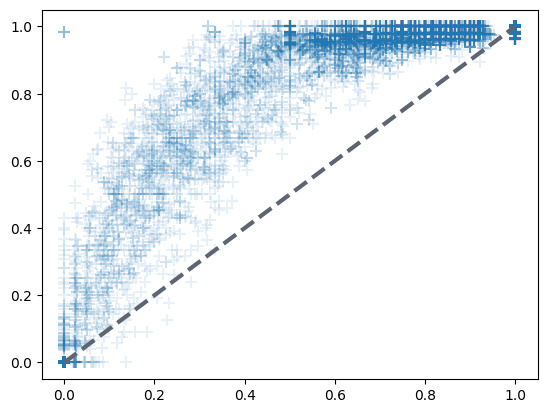

In [15]:
plt.scatter(FPRv, TPRv, s = 80, alpha = 0.1, marker = '+')
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color = '#5e6472', linewidth = 3, linestyle = '--')
plt.show()


In [16]:
tvunique = np.unique(tv_)

FPRm, TPRm = np.zeros(len(tvunique)), np.zeros(len(tvunique))
FPRu, TPRu = np.zeros(len(tvunique)), np.zeros(len(tvunique))
FPRd, TPRd = np.zeros(len(tvunique)), np.zeros(len(tvunique))

for i, t in enumerate(tvunique):
    idx = tv_ == t

    x, y = FPRv[idx], TPRv[idx]
    FPRm[i], TPRm[i] = np.mean(x), np.mean(y)
    FPRu[i], TPRu[i] = np.percentile(x, 5), np.percentile(y, 90)
    FPRd[i], TPRd[i] = np.percentile(x, 95), np.percentile(y, 10)

In [19]:
idx = np.argsort(FPRm)
auc(FPRm[idx], TPRm[idx])

0.7638970963316284